# Fashion MNIST 모델 구현


-  커스텀 데이터셋 생성

- 커스텀 모델 생성

- 학습/테스트 함수 생성

In [24]:
# 모델 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 성능지표 
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# 데이터 처리 및 시각화 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import * 

from sklearn.model_selection import train_test_split

## [1] 데이터 준비

In [25]:
from urllib.request import urlretrieve

TEST_URL  = 'https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_test.csv'
TRAIN_URL = 'https://media.githubusercontent.com/media/fpleoni/fashion_mnist/master/fashion-mnist_train.csv'

TRAIN_FILE = '../DATA/fashion-mnist_train.csv'
TEST_FILE  = '../DATA/fashion-mnist_test.csv'
# 데이터 파일로 저장
urlretrieve(TRAIN_URL, TRAIN_FILE)
urlretrieve(TEST_URL, TEST_FILE)

('../DATA/fashion-mnist_test.csv', <http.client.HTTPMessage at 0x2807871dd30>)

In [26]:
train_file = pd.read_csv(TRAIN_FILE)
test_file = pd.read_csv(TEST_FILE)

In [27]:
train_file.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
test_file.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [30]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [31]:
train_file['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [32]:
test_file['label'].unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9], dtype=int64)

## [2] 커스텀 데이터셋 생성

In [33]:
class mnist_data_set(Dataset):
    def __init__(self, feature_df, target_df):
        super().__init__()

        self.feature_df = feature_df
        self.target_df = target_df

    def __len__(self):
        return self.feature_df.shape[0]
    
    def __getitem__(self, index):
        feature_ts = torch.FloatTensor(self.feature_df.iloc[index])
        target_ts = torch.FloatTensor(self.target_df.iloc[index])

        return feature_ts, target_ts

In [34]:
train_file.shape

(60000, 785)

In [35]:
# train
train_feature_df = train_file[train_file.columns[1:]]
train_target_df = train_file[[train_file.columns[0]]]

print(train_feature_df.shape, train_target_df.shape)

# test
test_feature_df = test_file[train_file.columns[1:]]
test_target_df = test_file[[train_file.columns[0]]]

print(test_feature_df.shape, test_target_df.shape)


(60000, 784) (60000, 1)
(10000, 784) (10000, 1)


In [36]:
# 커스텀 데이터셋 인스턴스 생성 

mnist_train_custom_ds = mnist_data_set(train_feature_df, train_target_df)
mnist_test_custom_ds = mnist_data_set(test_feature_df, test_target_df)

In [37]:
# 데이터로더 인스턴스 생성 

# train
mnist_train_dl = DataLoader(mnist_train_custom_ds, batch_size = 32)
for feature, target in mnist_train_dl:
    print(feature.shape, target.shape, '\n',feature, target)
    break

# test
mnist_test_dl = DataLoader(mnist_test_custom_ds, batch_size = 32)
for feature, target in mnist_test_dl:
    print(feature.shape, target.shape, '\n',feature, target)
    break


torch.Size([32, 784]) torch.Size([32, 1]) 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[2.],
        [9.],
        [6.],
        [0.],
        [3.],
        [4.],
        [4.],
        [5.],
        [4.],
        [8.],
        [0.],
        [8.],
        [9.],
        [0.],
        [2.],
        [2.],
        [9.],
        [3.],
        [3.],
        [3.],
        [8.],
        [7.],
        [4.],
        [4.],
        [0.],
        [4.],
        [4.],
        [8.],
        [7.],
        [1.],
        [5.],
        [0.]])
torch.Size([32, 784]) torch.Size([32, 1]) 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0

## [2] 커스텀 모델 생성

In [38]:
class mnist_custom_model(nn.Module):
    # 은닉층의 개수가 동적인 모델 

    def __init__(self, in_features, in_out, out_out, h_cnt):
        # 부모클래스 생성 
        super().__init__()
        # 자식 클래스의 인스턴스 속성 설정 
        self.input_layer = nn.Linear(in_features,in_out)    

        self.hidden_layer = nn.ModuleList()
        n = 15
        if h_cnt != 0: 
            for i in range(1,h_cnt+1):
                self.hidden_layer.append(nn.Linear(in_out - (i-1)*n, in_out - i*n))
            
        if h_cnt == 0:
            self.output_layer = nn.Linear(in_out,out_out)  
        else:
            self.output_layer = nn.Linear(in_out - (h_cnt)*n,out_out)  

    def forward(self, x): # 데이터를 넣어야 함
        y = self.input_layer(x)     
        y = F.relu(y)               

        for h_layer in self.hidden_layer:  # ModuleList의 각 hidden_layer에 적용 
            y = h_layer(y)
            y = F.relu(y)

        return F.sigmoid(self.output_layer(y))

In [39]:
model = mnist_custom_model(784, 100,10,5)
model

mnist_custom_model(
  (input_layer): Linear(in_features=784, out_features=100, bias=True)
  (hidden_layer): ModuleList(
    (0): Linear(in_features=100, out_features=85, bias=True)
    (1): Linear(in_features=85, out_features=70, bias=True)
    (2): Linear(in_features=70, out_features=55, bias=True)
    (3): Linear(in_features=55, out_features=40, bias=True)
    (4): Linear(in_features=40, out_features=25, bias=True)
  )
  (output_layer): Linear(in_features=25, out_features=10, bias=True)
)

In [40]:
summary(model)

Layer (type:depth-idx)                   Param #
mnist_custom_model                       --
├─Linear: 1-1                            78,500
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       8,585
│    └─Linear: 2-2                       6,020
│    └─Linear: 2-3                       3,905
│    └─Linear: 2-4                       2,240
│    └─Linear: 2-5                       1,025
├─Linear: 1-3                            260
Total params: 100,535
Trainable params: 100,535
Non-trainable params: 0

## [3] 학습 / 테스트 함수 생성

In [41]:
EPOCH = 400
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.0001

In [42]:
# 최적화 인스턴스 => w, b 텐서 즉, model.parameters() 전달 
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss 
cross_loss = nn.CrossEntropyLoss()

In [43]:
def training(EPOCH, mnist_train_dl, mnist_test_custom_ds):
    LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
    CNT = len(mnist_train_dl)
    print(f'CNT : {CNT}')
    
    for epoch in range(EPOCH+1):

        # 학습 모드로 모델 설정 
        model.train()

        # 배치 크기 만큼 데이터 로딩해서 학습 진행 
        loss_total, score_total = 0,0
        for feature_ts, target_ts in mnist_train_dl: 

            # 학습 진행 
            pre_y = model(feature_ts)

            # 손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D, 타입은 long 
            loss = cross_loss(pre_y, target_ts.reshape(-1).long())
            loss_total += loss.item() 

            # 성능 평가 계산 
            score = MulticlassF1Score(num_classes=10)(pre_y, target_ts.reshape(-1)) 
            score_total += score.item()  

            # 최적화 진행 
            optimizer.zero_grad()       
            loss.backward()
            optimizer.step()

        # 에포크 당 검증기능 
        # 모델 검증 모드 설정 
        model.eval()

        with torch.no_grad():
            # 검증 데이터셋 
            test_feature_ts = torch.FloatTensor(mnist_test_custom_ds.feature_df.values) 
            test_target_ts = torch.FloatTensor(mnist_test_custom_ds.target_df.values)

            # 평가 
            pre_test =model(test_feature_ts)
            
            # 손실 
            loss_test = cross_loss(pre_test, test_target_ts.reshape(-1).long())

            # 성능 평가 
            score_test = MulticlassF1Score(num_classes=10)(pre_test, test_target_ts.reshape(-1))


        # for문 다 돌면 1 epoch 종료 
        # 손실값과 성능평가값 저장 
        LOSS_HISTORY[0].append(loss_total/CNT)
        SCORE_HISTORY[0].append(score_total/CNT)

        LOSS_HISTORY[1].append(loss_test)
        SCORE_HISTORY[1].append(score_test)

        print(f'[{epoch}/{EPOCH}]\n- Train Loss : {LOSS_HISTORY[0][-1]} Score : {SCORE_HISTORY[0][-1]}')
        print(f'- Val Loss : {LOSS_HISTORY[1][-1]} Score : {SCORE_HISTORY[1][-1]}')

    return LOSS_HISTORY, SCORE_HISTORY

In [44]:
loss, score = training(EPOCH, mnist_train_dl, mnist_test_custom_ds)

CNT : 1875
[0/400]
- Train Loss : 1.7088184277852376 Score : 0.406272484280169
- Val Loss : 1.6275217533111572 Score : 0.5260186791419983
[1/400]
- Train Loss : 1.6216247208913168 Score : 0.49474209977785744
- Val Loss : 1.6132464408874512 Score : 0.5212175846099854
[2/400]
- Train Loss : 1.6062451601028442 Score : 0.50375623691082
- Val Loss : 1.6085830926895142 Score : 0.5263147354125977
[3/400]
- Train Loss : 1.5956417667388916 Score : 0.5276624707063039
- Val Loss : 1.5945167541503906 Score : 0.5483284592628479
[4/400]
- Train Loss : 1.5906406465530396 Score : 0.550240542793274
- Val Loss : 1.5971653461456299 Score : 0.6059712767601013
[5/400]
- Train Loss : 1.583643997001648 Score : 0.5881656678040822
- Val Loss : 1.5840729475021362 Score : 0.6185973286628723
[6/400]
- Train Loss : 1.578724067433675 Score : 0.5999042483329773
- Val Loss : 1.5818355083465576 Score : 0.646812379360199
[7/400]
- Train Loss : 1.5752909192403157 Score : 0.6026745481173198
- Val Loss : 1.576686382293701

Text(0.5, 1.0, 'F1SCORE')

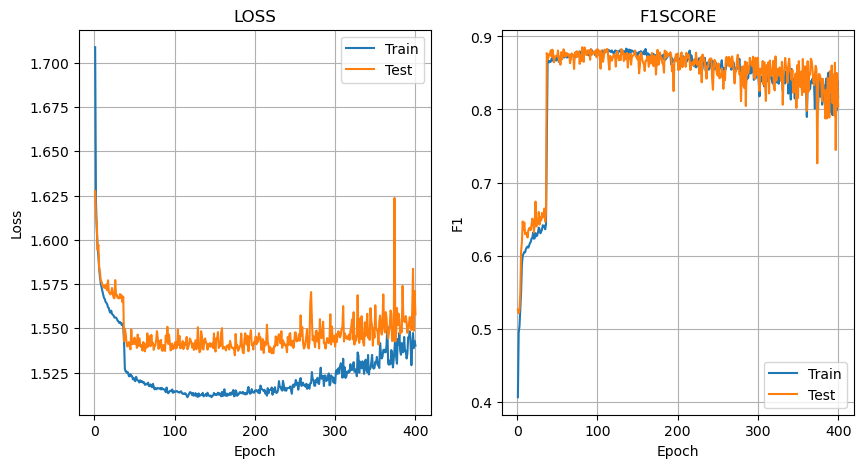

In [45]:
fg, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,EPOCH+1) ,loss[0][:EPOCH], label = 'Train')
axes[0].plot(range(1,EPOCH+1), loss[1][:EPOCH], label = 'Test')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,EPOCH+1) ,score[0][:EPOCH], label = 'Train')
axes[1].plot(range(1,EPOCH+1), score[1][:EPOCH], label = 'Test')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1')
axes[1].set_title('F1SCORE')

Text(0.5, 1.0, 'F1SCORE')

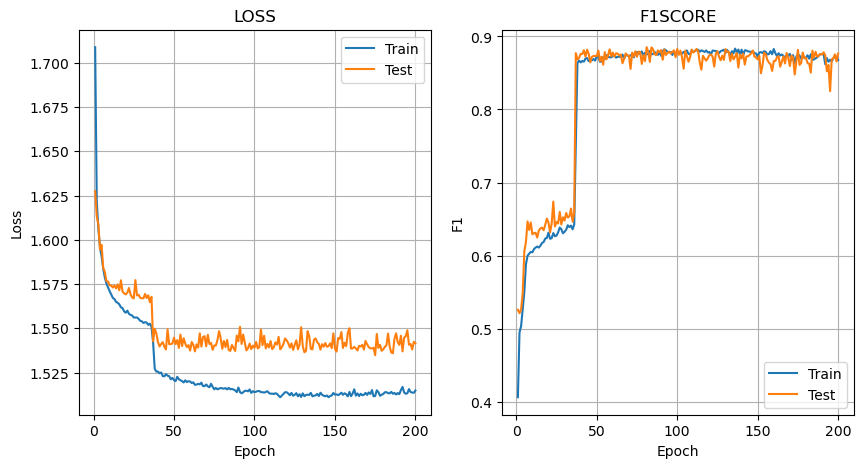

In [48]:
THRESHOLD = 200

fg, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,THRESHOLD+1) ,loss[0][:THRESHOLD], label = 'Train')
axes[0].plot(range(1,THRESHOLD+1), loss[1][:THRESHOLD], label = 'Test')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,THRESHOLD+1) ,score[0][:THRESHOLD], label = 'Train')
axes[1].plot(range(1,THRESHOLD+1), score[1][:THRESHOLD], label = 'Test')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1')
axes[1].set_title('F1SCORE')